# Task 2 -  Data Modeling and Transformation (Transform)
**Under this Task the following activities are accomplished
- the scraped JSON files from my data lake was loaded into a raw schema in my PostgreSQL database.
- Installing  dbt and its PostgreSQL adapter and setting  up a DBT project.
- by Initialize a DBT project connection  to  PostgreSQL database.


In [ ]:
# import dependencies
import json
from pathlib import Path
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import logging
import sys 
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import psycopg2
from psycopg2.extras import Json

In [ ]:

# PostgreSQL connection
conn = psycopg2.connect(
    dbname="kara_medical_db",
    user="postgres",
    password="*****",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

# Create raw schema if not exists
cur.execute("CREATE SCHEMA IF NOT EXISTS raw;")

# Drop old table (optional, good for dev to avoid missing columns issue)
cur.execute("DROP TABLE IF EXISTS raw.telegram_messages;")

# Create raw table with correct schema
cur.execute("""
CREATE TABLE raw.telegram_messages (
    message_id BIGINT,
    sender_id BIGINT,
    message_text TEXT,
    posted_at TIMESTAMPTZ,
    views INT,
    forwards INT,
    media_url TEXT,
    raw_json JSONB,
    PRIMARY KEY (sender_id, message_id)  -- composite key for ON CONFLICT
);
""")
conn.commit()

# Load JSON files
data_dir = "F:/Intelligent_Ethiopian_Medical_Business_peplines-/data/raw/telegram_messages"
for file in os.listdir(data_dir):
    if file.endswith(".json"):
        with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
            messages = json.load(f)
            for msg in messages:
                cur.execute("""
                    INSERT INTO raw.telegram_messages
                    (message_id, sender_id, message_text, posted_at, views, forwards, media_url, raw_json)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                    ON CONFLICT (sender_id, message_id) DO NOTHING;
                """, (
                    msg.get("message_id"),
                    msg.get("sender_id"),
                    msg.get("text"),
                    msg.get("date"),
                    msg.get("views"),
                    msg.get("forwards"),
                    msg.get("media"),
                    json.dumps(msg)
                ))

conn.commit()
cur.close()
conn.close()


In [ ]:

conn = psycopg2.connect(
    dbname="kara_medical_db",
    user="postgres",
    password="****",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

cur.execute("SELECT COUNT(*) FROM raw.telegram_messages;")
print("Total messages:", cur.fetchone()[0])

cur.close()
conn.close()


Total messages: 276


In [ ]:
import psycopg2
import pandas as pd

# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname="kara_medical_db",
    user="postgres",
    password="****",
    host="localhost",
    port="5432"
)

# Example: Load all data (or use LIMIT to test first)
query = "SELECT * FROM raw.telegram_messages;"
df = pd.read_sql(query, conn)

conn.close()

# Preview
df.head()



C:\Users\user\AppData\Local\Temp\ipykernel_80712\137496099.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,message_id,sender_id,message_text,posted_at,views,forwards,media_url,raw_json
0,97,-1001627056354,"⚠️**Notice!\n**Dear esteemed customers,\nDue t...",2023-02-10 12:23:06+00:00,1226,1,F:\Intelligent_Ethiopian_Medical_Business_pepl...,"{'date': '2023-02-10T12:23:06+00:00', 'text': ..."
1,96,-1001627056354,Mela-One በውስጡ ሆርሞን ያለው ድንገተኛ ወሊድ መቆጣጠርያ ሲሆን ያለ...,2023-02-02 08:58:52+00:00,1124,3,F:\Intelligent_Ethiopian_Medical_Business_pepl...,"{'date': '2023-02-02T08:58:52+00:00', 'text': ..."
2,95,-1001627056354,**አዚትሮማይሲን** በሃኪም መድሃኒት ማዘዣ ከሚታዘዙ አንቲባዮቲኮች አንዱ...,2023-02-01 08:59:37+00:00,1016,4,F:\Intelligent_Ethiopian_Medical_Business_pepl...,"{'date': '2023-02-01T08:59:37+00:00', 'text': ..."
3,94,-1001627056354,**Che-Med Trivia #3\n\n**ምግብና መጠጦች አንዳንድ መድሃኒቶ...,2023-01-31 09:19:53+00:00,784,1,F:\Intelligent_Ethiopian_Medical_Business_pepl...,"{'date': '2023-01-31T09:19:53+00:00', 'text': ..."
4,93,-1001627056354,"**Che-Med Trivia #2\n\n**እንደ Ciprofloxacin, Do...",2023-01-30 09:45:25+00:00,681,2,F:\Intelligent_Ethiopian_Medical_Business_pepl...,"{'date': '2023-01-30T09:45:25+00:00', 'text': ..."


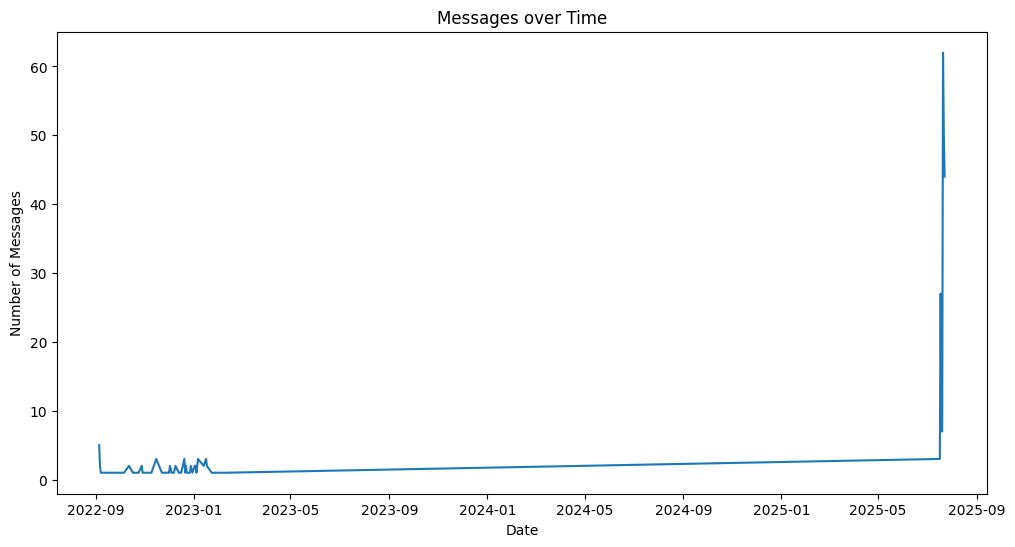

In [27]:
import matplotlib.pyplot as plt

df["posted_at"] = pd.to_datetime(df["posted_at"])
daily_counts = df.groupby(df["posted_at"].dt.date).size()

plt.figure(figsize=(12,6))
daily_counts.plot(kind="line")
plt.title("Messages over Time")
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.show()


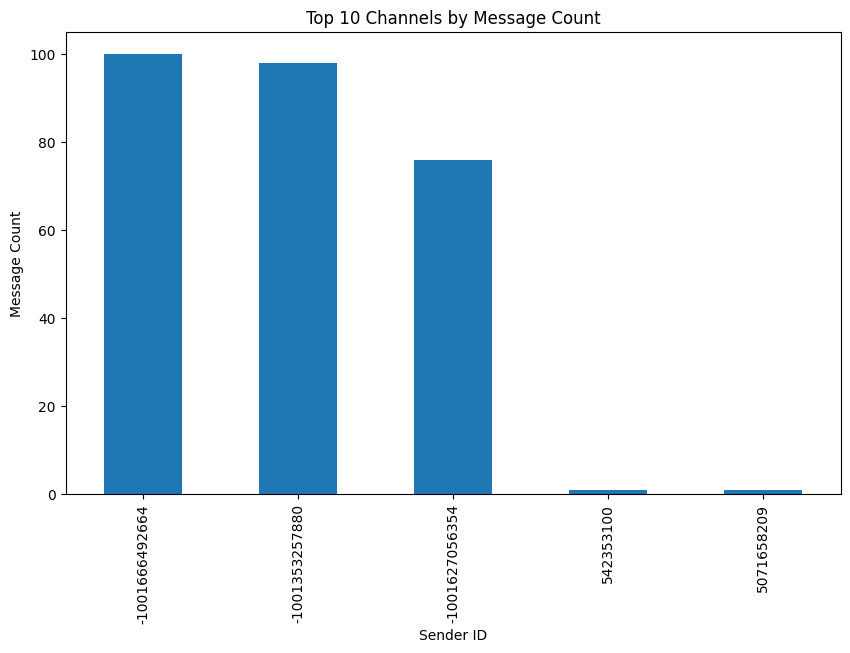

In [28]:
df["sender_id"].value_counts().head(10).plot(kind="bar", figsize=(10,6))
plt.title("Top 10 Channels by Message Count")
plt.xlabel("Sender ID")
plt.ylabel("Message Count")
plt.show()


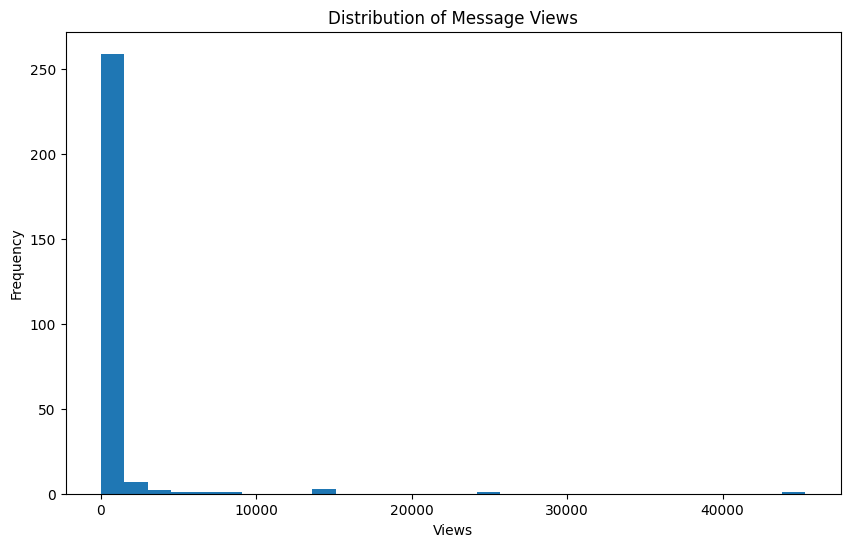

In [29]:
df["views"].dropna().plot(kind="hist", bins=30, figsize=(10,6))
plt.title("Distribution of Message Views")
plt.xlabel("Views")
plt.ylabel("Frequency")
plt.show()
